# Custom Multiclass Decision Tree with Sklearn Pipeline

**Focus:** Custom multiclass decision tree with sklearn preprocessing/features (SAME pipeline as notebook 7)

**Pipeline:**
1. ✅ Sklearn preprocessing (SimpleImputer) - SAME AS NOTEBOOK 7
2. ✅ Feature engineering (statistical + temporal) - SAME AS NOTEBOOK 7
3. ✅ **Multiclass label creation** from train_tte.csv - DIFFERS FROM NOTEBOOK 7
4. ✅ Sklearn feature selection (mutual information) - SAME AS NOTEBOOK 7
5. ✅ **CUSTOM multiclass decision tree** (core contribution)
6. ✅ Compare with sklearn DecisionTreeClassifier

**Dataset:** Scania Component X (Version 2)
- Training: 23,550 vehicles → Convert binary to 5-class based on time-to-failure
- Validation: 5,046 vehicles (already has 5-class labels)

**Class labels (0-4):**
- **Class 0**: No failure or >48 timesteps away
- **Class 1**: Failed within 24-48 timesteps  
- **Class 2**: Failed within 12-24 timesteps
- **Class 3**: Failed within 6-12 timesteps
- **Class 4**: Failed within 0-6 timesteps (IMMINENT)

---
## 1. Setup

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time

# Sklearn
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import mutual_info_classif

pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')
%matplotlib inline

print(" Libraries imported")

 Libraries imported


---
## 2. Load Data

In [37]:
print(" Loading raw data...")
train_ops = pd.read_csv('../data/raw/train_operational_readouts.csv')
val_ops = pd.read_csv('../data/raw/validation_operational_readouts.csv')
train_tte = pd.read_csv('../data/raw/train_tte.csv')
val_labels = pd.read_csv('../data/raw/validation_labels.csv')

print(f" Data loaded:")
print(f"   Train ops: {train_ops.shape}")
print(f"   Val ops: {val_ops.shape}")
print(f"   Train labels: {train_tte.shape}")
print(f"   Val labels: {val_labels.shape}")
print(f"   Missing values: {train_ops.isnull().sum().sum():,} train + {val_ops.isnull().sum().sum():,} val")

print(f"\nValidation class distribution:")
print(val_labels['class_label'].value_counts().sort_index())

 Loading raw data...
 Data loaded:
   Train ops: (1122452, 107)
   Val ops: (196227, 107)
   Train labels: (23550, 3)
   Val labels: (5046, 2)
   Missing values: 354,634 train + 60,339 val

Validation class distribution:
class_label
0    4910
1      16
2      14
3      30
4      76
Name: count, dtype: int64


---
## 3. Create Multiclass Labels for Training Data

**Goal:** Convert binary training labels to 5-class labels matching validation dataset.

**Strategy:**
- For vehicles that fail (`in_study_repair == 1`), calculate time-to-failure at each timestep
- Assign class based on proximity to failure:
  - Class 0: No failure or >48 timesteps away
  - Class 1: 24-48 timesteps before failure
  - Class 2: 12-24 timesteps before failure  
  - Class 3: 6-12 timesteps before failure
  - Class 4: 0-6 timesteps before failure (critical)

In [38]:
print(" Creating multiclass labels from time-to-failure...")
start_time = time.time()

# Merge operational data with TTE info
train_merged = train_ops.merge(train_tte[['vehicle_id', 'length_of_study_time_step', 'in_study_repair']], 
                                on='vehicle_id', how='left')

# Calculate time until failure for each reading
train_merged['time_until_failure'] = train_merged['length_of_study_time_step'] - train_merged['time_step']

# Assign multiclass labels
def assign_multiclass_label(row):
    """Convert time-to-failure into 5-class labels"""
    if row['in_study_repair'] == 0:
        return 0  # No failure
    else:
        ttf = row['time_until_failure']
        if ttf > 48:
            return 0  # Far from failure
        elif ttf > 24:
            return 1  # 24-48 timesteps
        elif ttf > 12:
            return 2  # 12-24 timesteps
        elif ttf > 6:
            return 3  # 6-12 timesteps
        else:
            return 4  # 0-6 timesteps (imminent)

train_merged['class_label'] = train_merged.apply(assign_multiclass_label, axis=1)

label_time = time.time() - start_time

print(f" Multiclass labels created! ({label_time:.2f}s)")
print(f"\nClass distribution (at row level, {len(train_merged):,} rows):")
print(train_merged['class_label'].value_counts().sort_index())
print(f"\nPercentages:")
print((train_merged['class_label'].value_counts(normalize=True).sort_index() * 100).round(2))

 Creating multiclass labels from time-to-failure...
 Multiclass labels created! (3.33s)

Class distribution (at row level, 1,122,452 rows):
class_label
0    1096712
1      12503
2       6179
3       3200
4       3858
Name: count, dtype: int64

Percentages:
class_label
0    97.71
1     1.11
2     0.55
3     0.29
4     0.34
Name: proportion, dtype: float64


---
## 4. Preprocessing (Sklearn SimpleImputer)

**Same as Notebook 7:** Using sklearn's SimpleImputer with median strategy

In [39]:
print("🔧 PREPROCESSING: Sklearn SimpleImputer with median strategy")
start_time = time.time()

# Identify sensor columns (exclude metadata and labels)
id_cols = ['vehicle_id', 'time_step', 'length_of_study_time_step', 'in_study_repair', 
           'time_until_failure', 'class_label']
sensor_cols = [col for col in train_merged.columns if col not in id_cols]

# Sklearn median imputation
imputer = SimpleImputer(strategy='median')
imputer.fit(train_merged[sensor_cols])

train_processed = train_merged.copy()
val_processed = val_ops.copy()

train_processed[sensor_cols] = imputer.transform(train_processed[sensor_cols])
val_processed[sensor_cols] = imputer.transform(val_processed[sensor_cols])

preproc_time = time.time() - start_time

print(f" Preprocessing complete! ({preproc_time:.2f}s)")
print(f"   Train missing: {train_processed[sensor_cols].isnull().sum().sum()}")
print(f"   Val missing: {val_processed[sensor_cols].isnull().sum().sum()}")

🔧 PREPROCESSING: Sklearn SimpleImputer with median strategy
 Preprocessing complete! (18.48s)
   Train missing: 0
   Val missing: 0


---
## 5. Feature Engineering

**Same as Notebook 7:** Statistical + temporal features using pandas aggregation

In [40]:
def create_statistical_features(df, sensor_cols):
    """Create statistical features using pandas aggregation"""
    agg_dict = {}
    for col in sensor_cols:
        if col in df.columns and col not in ['vehicle_id', 'time_step']:
            agg_dict[f'{col}_mean'] = (col, 'mean')
            agg_dict[f'{col}_median'] = (col, 'median')
            agg_dict[f'{col}_std'] = (col, 'std')
            agg_dict[f'{col}_min'] = (col, 'min')
            agg_dict[f'{col}_max'] = (col, 'max')
    return df.groupby('vehicle_id').agg(**agg_dict).reset_index()

def create_temporal_features(df, sensor_cols):
    """Create temporal features for cumulative sensors"""
    temporal_features = []
    cumulative_sensors = [col for col in sensor_cols if '167_' in col]
    
    for vehicle_id, group in df.groupby('vehicle_id'):
        vehicle_features = {'vehicle_id': vehicle_id}
        for col in cumulative_sensors:
            if col in group.columns:
                values = group[col].values
                vehicle_features[f'{col}_last'] = values[-1]
                if len(values) > 1:
                    x = np.arange(len(values))
                    slope = np.polyfit(x, values, 1)[0]
                    vehicle_features[f'{col}_trend'] = slope
                else:
                    vehicle_features[f'{col}_trend'] = 0
                vehicle_features[f'{col}_volatility'] = np.std(values)
        temporal_features.append(vehicle_features)
    return pd.DataFrame(temporal_features)

print(" Feature engineering functions defined")

 Feature engineering functions defined


In [41]:
print(" Creating features...")
start_time = time.time()

# Statistical features
train_stat = create_statistical_features(train_processed, sensor_cols)
val_stat = create_statistical_features(val_processed, sensor_cols)

# Temporal features
train_temp = create_temporal_features(train_processed, sensor_cols)
val_temp = create_temporal_features(val_processed, sensor_cols)

# Merge features
X_train_features = train_stat.merge(train_temp, on='vehicle_id', how='inner')
X_val_features = val_stat.merge(val_temp, on='vehicle_id', how='inner')

# Get LAST reading's class label for each vehicle (closest to failure)
train_last_labels = train_processed.sort_values('time_step').groupby('vehicle_id').last()[['class_label']].reset_index()
X_train_features = X_train_features.merge(train_last_labels, on='vehicle_id', how='inner')
X_val_features = X_val_features.merge(val_labels, on='vehicle_id', how='inner')

# Extract X and y
y_train = X_train_features['class_label'].values
y_val = X_val_features['class_label'].values
X_train = X_train_features.drop(['vehicle_id', 'class_label'], axis=1).values
X_val = X_val_features.drop(['vehicle_id', 'class_label'], axis=1).values

feat_eng_time = time.time() - start_time

print(f" Features created! ({feat_eng_time:.2f}s)")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")

print(f"\nTraining class distribution (per vehicle, using LAST label):")
train_dist = pd.Series(y_train).value_counts().sort_index()
for cls, count in train_dist.items():
    pct = count / len(y_train) * 100
    print(f"   Class {cls}: {count:5d} ({pct:5.2f}%)")

print(f"\nValidation class distribution:")
val_dist = pd.Series(y_val).value_counts().sort_index()
for cls, count in val_dist.items():
    pct = count / len(y_val) * 100
    print(f"   Class {cls}: {count:5d} ({pct:5.2f}%)")

 Creating features...
 Features created! (26.76s)
   X_train: (23550, 555)
   X_val: (5046, 555)

Training class distribution (per vehicle, using LAST label):
   Class 0: 21288 (90.39%)
   Class 1:    31 ( 0.13%)
   Class 2:    70 ( 0.30%)
   Class 3:   161 ( 0.68%)
   Class 4:  2000 ( 8.49%)

Validation class distribution:
   Class 0:  4910 (97.30%)
   Class 1:    16 ( 0.32%)
   Class 2:    14 ( 0.28%)
   Class 3:    30 ( 0.59%)
   Class 4:    76 ( 1.51%)


---
## 6. Feature Selection (Sklearn Mutual Information)

**Same as Notebook 7:** Using sklearn's mutual_info_classif to select top 100 features

In [42]:
print(" FEATURE SELECTION: Sklearn mutual_info_classif")
start_time = time.time()

# Select top 100 features using mutual information
top_k = 100
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)
top_indices = np.argsort(mi_scores)[::-1][:top_k]

X_train_selected = X_train[:, top_indices]
X_val_selected = X_val[:, top_indices]

fs_time = time.time() - start_time

print(f" Feature selection complete! ({fs_time:.2f}s)")
print(f"   Features: {X_train.shape[1]} → {X_train_selected.shape[1]}")
print(f"   Top 5 MI scores: {mi_scores[top_indices[:5]]}")

 FEATURE SELECTION: Sklearn mutual_info_classif
 Feature selection complete! (33.20s)
   Features: 555 → 100
   Top 5 MI scores: [0.0127844  0.01146696 0.01124576 0.01089144 0.01086599]


---
## 7. Custom Multiclass Decision Tree Implementation

**Modified from Notebook 7:** Handles multiclass classification (5 classes instead of 2)

In [43]:
# Core functions for multiclass decision tree
def gini_impurity(y, sample_weights=None):
    """Calculate Gini impurity for multiclass with optional sample weights"""
    if len(y) == 0:
        return 0
    
    if sample_weights is None:
        sample_weights = np.ones(len(y))
    
    classes = np.unique(y)
    total_weight = np.sum(sample_weights)
    
    if total_weight == 0:
        return 0
    
    gini = 1.0
    for c in classes:
        class_weight = np.sum(sample_weights[y == c])
        p = class_weight / total_weight
        gini -= p ** 2
    
    return gini

def information_gain(y_parent, y_left, y_right, weights_parent=None, weights_left=None, weights_right=None):
    """Calculate information gain from a split with optional sample weights"""
    gini_parent = gini_impurity(y_parent, weights_parent)
    
    if weights_parent is not None:
        total_weight = np.sum(weights_parent)
        left_weight = np.sum(weights_left) if weights_left is not None else len(y_left)
        right_weight = np.sum(weights_right) if weights_right is not None else len(y_right)
    else:
        total_weight = len(y_parent)
        left_weight = len(y_left)
        right_weight = len(y_right)
    
    if left_weight == 0 or right_weight == 0:
        return 0
    
    gini_left = gini_impurity(y_left, weights_left)
    gini_right = gini_impurity(y_right, weights_right)
    weighted_child_impurity = (left_weight / total_weight) * gini_left + (right_weight / total_weight) * gini_right
    return gini_parent - weighted_child_impurity

class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
    
    def is_leaf(self):
        return self.value is not None

class MulticlassDecisionTree:
    def __init__(self, max_depth=10, min_samples_split=2, min_samples_leaf=1, class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.class_weight = class_weight
        self.root = None
        self.n_features = None
        self.class_weights_ = None
    
    def fit(self, X, y):
        self.n_features = X.shape[1]
        
        # Calculate class weights if class_weight='balanced'
        if self.class_weight == 'balanced':
            classes, counts = np.unique(y, return_counts=True)
            n_samples = len(y)
            n_classes = len(classes)
            self.class_weights_ = {c: (n_samples / (n_classes * count)) for c, count in zip(classes, counts)}
            print(f"   Class weights: {self.class_weights_}")
        elif isinstance(self.class_weight, dict):
            self.class_weights_ = self.class_weight
            print(f"   Class weights: {self.class_weights_}")
        else:
            self.class_weights_ = None
        
        # Create sample weights array
        if self.class_weights_ is not None:
            sample_weights = np.array([self.class_weights_[label] for label in y])
        else:
            sample_weights = None
        
        self.root = self._build_tree(X, y, sample_weights, depth=0)
        return self
    
    def _build_tree(self, X, y, sample_weights, depth):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (depth >= self.max_depth or n_samples < self.min_samples_split or n_classes == 1):
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold = self._best_split(X, y, sample_weights)
        
        if best_feature is None:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = X[:, best_feature] > best_threshold
        
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._most_common_label(y, sample_weights)
            return Node(value=leaf_value)
        
        # Split weights along with data
        weights_left = sample_weights[left_indices] if sample_weights is not None else None
        weights_right = sample_weights[right_indices] if sample_weights is not None else None
        
        # Recursively build subtrees
        left_child = self._build_tree(X[left_indices], y[left_indices], weights_left, depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], weights_right, depth + 1)
        
        return Node(feature=best_feature, threshold=best_threshold, left=left_child, right=right_child)
    
    def _best_split(self, X, y, sample_weights):
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]
            # Speed optimization: max 20 thresholds via percentiles
            thresholds = np.unique(feature_values)
            if len(thresholds) > 20:
                thresholds = np.percentile(feature_values, np.linspace(0, 100, 20))
            
            for threshold in thresholds:
                left_indices = feature_values <= threshold
                right_indices = feature_values > threshold
                
                if np.sum(left_indices) == 0 or np.sum(right_indices) == 0:
                    continue
                
                y_left = y[left_indices]
                y_right = y[right_indices]
                weights_left = sample_weights[left_indices] if sample_weights is not None else None
                weights_right = sample_weights[right_indices] if sample_weights is not None else None
                
                gain = information_gain(y, y_left, y_right, sample_weights, weights_left, weights_right)
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature_idx
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _most_common_label(self, y, sample_weights=None):
        if sample_weights is None:
            counter = Counter(y)
            return counter.most_common(1)[0][0]
        else:
            # Weighted voting
            classes = np.unique(y)
            weighted_counts = {c: np.sum(sample_weights[y == c]) for c in classes}
            return max(weighted_counts, key=weighted_counts.get)
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

print(" Multiclass Decision Tree class defined")

 Multiclass Decision Tree class defined


---
## Summary

### ✅ Multiclass Pipeline Complete!

**What we used (SAME AS NOTEBOOK 7 except label creation):**
1. **Sklearn** for preprocessing (SimpleImputer with median strategy)
2. **Pandas** for feature engineering (statistical + temporal features)
3. **Sklearn** for feature selection (mutual information, top 100 features)
4. **CUSTOM multiclass decision tree** implementation (the core contribution)

**Key Difference from Notebook 7:**
- **Notebook 7**: Binary classification (healthy vs failed)
- **Notebook 8**: Multiclass classification (5 time-to-failure classes)
- **Label creation**: Convert training data from binary to 5-class using time-to-failure
- **Everything else**: IDENTICAL preprocessing and feature engineering pipeline

**Multiclass Labels:**
- **Class 0**: No failure or >48 timesteps away (low risk)
- **Class 1**: Failed within 24-48 timesteps (moderate risk)
- **Class 2**: Failed within 12-24 timesteps (elevated risk)
- **Class 3**: Failed within 6-12 timesteps (high risk)
- **Class 4**: Failed within 0-6 timesteps (CRITICAL - maintenance NOW!)

**Use Case:**
This provides **actionable lead time** for maintenance planning:
- Class 0 predictions: Normal operation
- Class 1-2 predictions: Schedule maintenance within days
- Class 3-4 predictions: Urgent maintenance required!

---
## 7. Ensemble Undersampling (EasyEnsemble Approach)

**Strategy:** Train multiple trees on balanced subsets to handle class imbalance

**How it works:**
1. Split majority class (Class 0: 21,288 samples) into batches of 2,000
2. Train separate tree on each batch + ALL minority class samples (Class 1-4)
3. Ensemble predictions via majority voting
4. All Class 0 data gets used (distributed across trees)

**Advantages:**
- ✅ Each tree sees balanced data (no class weights needed!)
- ✅ Ensemble diversity (each tree sees different Class 0 samples)
- ✅ Better generalization than single weighted tree
- ✅ All training data utilized

**Expected Results:**
- Better recall for minority classes (Class 1-4)
- Reduced false alarms (Class 0 correctly identified)
- More robust predictions through ensemble voting

In [44]:
class EnsembleUndersamplingClassifier:
    """
    Ensemble of decision trees trained on balanced subsets.
    
    Strategy:
    - Split majority class into batches
    - Train one tree per batch (batch + all minority samples)
    - Ensemble predictions via majority voting
    """
    
    def __init__(self, batch_size=2000, max_depth=10, min_samples_split=50, 
                 min_samples_leaf=10, random_state=42):
        self.batch_size = batch_size
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.trees = []
        self.n_trees = 0
    
    def fit(self, X, y):
        """
        Train ensemble of trees on balanced subsets
        
        Args:
            X: Feature matrix
            y: Labels
        """
        np.random.seed(self.random_state)
        
        # Separate majority (Class 0) from minority (Class 1-4)
        class_0_indices = np.where(y == 0)[0]
        minority_indices = np.where(y != 0)[0]
        
        print(f"\n Creating balanced batches:")
        print(f"   Class 0 samples: {len(class_0_indices):,}")
        print(f"   Minority samples (Class 1-4): {len(minority_indices):,}")
        print(f"   Batch size: {self.batch_size:,}")
        
        # Shuffle Class 0 indices
        np.random.shuffle(class_0_indices)
        
        # Split Class 0 into batches
        n_batches = int(np.ceil(len(class_0_indices) / self.batch_size))
        print(f"   Number of batches: {n_batches}")
        
        self.trees = []
        
        for i in range(n_batches):
            # Get current batch of Class 0
            start_idx = i * self.batch_size
            end_idx = min((i + 1) * self.batch_size, len(class_0_indices))
            batch_class_0 = class_0_indices[start_idx:end_idx]
            
            # Combine with ALL minority samples
            batch_indices = np.concatenate([batch_class_0, minority_indices])
            np.random.shuffle(batch_indices)
            
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            
            # Train tree on balanced batch (NO class weights needed!)
            tree = MulticlassDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                class_weight=None  # Balanced data, no weights needed!
            )
            
            tree.fit(X_batch, y_batch)
            self.trees.append(tree)
            
            # Progress update
            batch_dist = pd.Series(y_batch).value_counts().sort_index()
            print(f"   Batch {i+1}/{n_batches}: Class 0={len(batch_class_0)}, "
                  f"Class 1-4={len(minority_indices)}, Total={len(batch_indices)}")
        
        self.n_trees = len(self.trees)
        print(f"\n✅ Trained {self.n_trees} trees on balanced batches!")
        return self
    
    def predict(self, X):
        """
        Predict using majority voting across all trees
        
        Args:
            X: Feature matrix
        
        Returns:
            Predictions (majority vote)
        """
        # Get predictions from all trees
        all_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # Majority voting
        predictions = []
        for i in range(X.shape[0]):
            votes = all_predictions[:, i]
            # Count votes for each class
            vote_counts = Counter(votes)
            # Return class with most votes
            predictions.append(vote_counts.most_common(1)[0][0])
        
        return np.array(predictions)

print(" EnsembleUndersamplingClassifier defined")

 EnsembleUndersamplingClassifier defined


### Train Ensemble Undersampling Model

In [45]:
print("="*80)
print("ENSEMBLE UNDERSAMPLING: Training multiple trees on balanced batches")
print("="*80)

start_time = time.time()

# Create ensemble with batch_size=2000 (balances with minority classes)
ensemble_model = EnsembleUndersamplingClassifier(
    batch_size=2000,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=10,
    random_state=42
)

# Train on full training data (model handles splitting internally)
ensemble_model.fit(X_train_selected, y_train)

ensemble_train_time = time.time() - start_time

print(f"\n Total training time: {ensemble_train_time:.2f}s")
print(f"   Average time per tree: {ensemble_train_time/ensemble_model.n_trees:.2f}s")

# Predictions
print(f"\n Making predictions with {ensemble_model.n_trees}-tree ensemble...")
y_train_pred_ensemble = ensemble_model.predict(X_train_selected)
y_val_pred_ensemble = ensemble_model.predict(X_val_selected)

# Metrics
ensemble_acc_train = accuracy_score(y_train, y_train_pred_ensemble)
ensemble_acc_val = accuracy_score(y_val, y_val_pred_ensemble)
ensemble_f1_val = f1_score(y_val, y_val_pred_ensemble, average='macro', zero_division=0)

print(f"\n ENSEMBLE RESULTS:")
print(f"   Train Accuracy: {ensemble_acc_train:.4f}")
print(f"   Val Accuracy:   {ensemble_acc_val:.4f}")
print(f"   Val F1 (macro): {ensemble_f1_val:.4f}")

print(f"\n Classification Report:")
print(classification_report(y_val, y_val_pred_ensemble, 
                          target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'], 
                          zero_division=0))

print("="*80)

ENSEMBLE UNDERSAMPLING: Training multiple trees on balanced batches

 Creating balanced batches:
   Class 0 samples: 21,288
   Minority samples (Class 1-4): 2,262
   Batch size: 2,000
   Number of batches: 11
   Batch 1/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 2/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 3/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 4/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 5/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 6/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 7/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 8/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 9/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 10/11: Class 0=2000, Class 1-4=2262, Total=4262
   Batch 11/11: Class 0=1288, Class 1-4=2262, Total=3550

✅ Trained 11 trees on balanced batches!

 Total training time: 141.32s
   Average time per tree: 12.85s

 Making predictions with 11-tree ensemble...

 ENSEMBLE RESULTS:
  

### Compare: Ensemble vs Single Tree vs Sklearn

In [46]:
print("="*80)
print("COMPARISON: Ensemble Undersampling vs Single Tree vs Sklearn")
print("="*80)

comparison_results = pd.DataFrame({
    'Model': ['Custom Single Tree', 'Sklearn Tree', 'Ensemble Undersampling'],
    'Val Accuracy': [
        f"{custom_acc_val:.4f}",
        f"{sklearn_acc_val:.4f}",
        f"{ensemble_acc_val:.4f}"
    ],
    'Val F1 (macro)': [
        f"{f1_score(y_val, y_val_pred_custom, average='macro', zero_division=0):.4f}",
        f"{f1_score(y_val, y_val_pred_sklearn, average='macro', zero_division=0):.4f}",
        f"{ensemble_f1_val:.4f}"
    ],
    'Training Time (s)': [
        f"{custom_train_time:.2f}",
        f"{sklearn_train_time:.2f}",
        f"{ensemble_train_time:.2f}"
    ],
    'Strategy': [
        'Class weights',
        'Class weights (sklearn)',
        f'{ensemble_model.n_trees} trees on balanced batches'
    ]
})

print("\n" + comparison_results.to_string(index=False))

# Per-class comparison for Class 4 (most critical)
print(f"\n CLASS 4 (CRITICAL - 0-6 timesteps) Performance:")
print(f"{'Model':<25} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 61)

for model_name, y_pred in [
    ('Custom Single Tree', y_val_pred_custom),
    ('Sklearn Tree', y_val_pred_sklearn),
    ('Ensemble Undersampling', y_val_pred_ensemble)
]:
    class_report = classification_report(y_val, y_pred, output_dict=True, zero_division=0)
    class_4_metrics = class_report['4']
    print(f"{model_name:<25} {class_4_metrics['precision']:<12.4f} "
          f"{class_4_metrics['recall']:<12.4f} {class_4_metrics['f1-score']:<12.4f}")

print("\n" + "="*80)

COMPARISON: Ensemble Undersampling vs Single Tree vs Sklearn

                 Model Val Accuracy Val F1 (macro) Training Time (s)                     Strategy
    Custom Single Tree       0.3266         0.1122             34.03                Class weights
          Sklearn Tree       0.2800         0.0959              2.14      Class weights (sklearn)
Ensemble Undersampling       0.5040         0.1426            141.32 11 trees on balanced batches

 CLASS 4 (CRITICAL - 0-6 timesteps) Performance:
Model                     Precision    Recall       F1-Score    
-------------------------------------------------------------
Custom Single Tree        0.0230       0.5000       0.0440      
Sklearn Tree              0.0196       0.6842       0.0381      
Ensemble Undersampling    0.0226       0.7500       0.0438      



### Confusion Matrix: Ensemble Undersampling

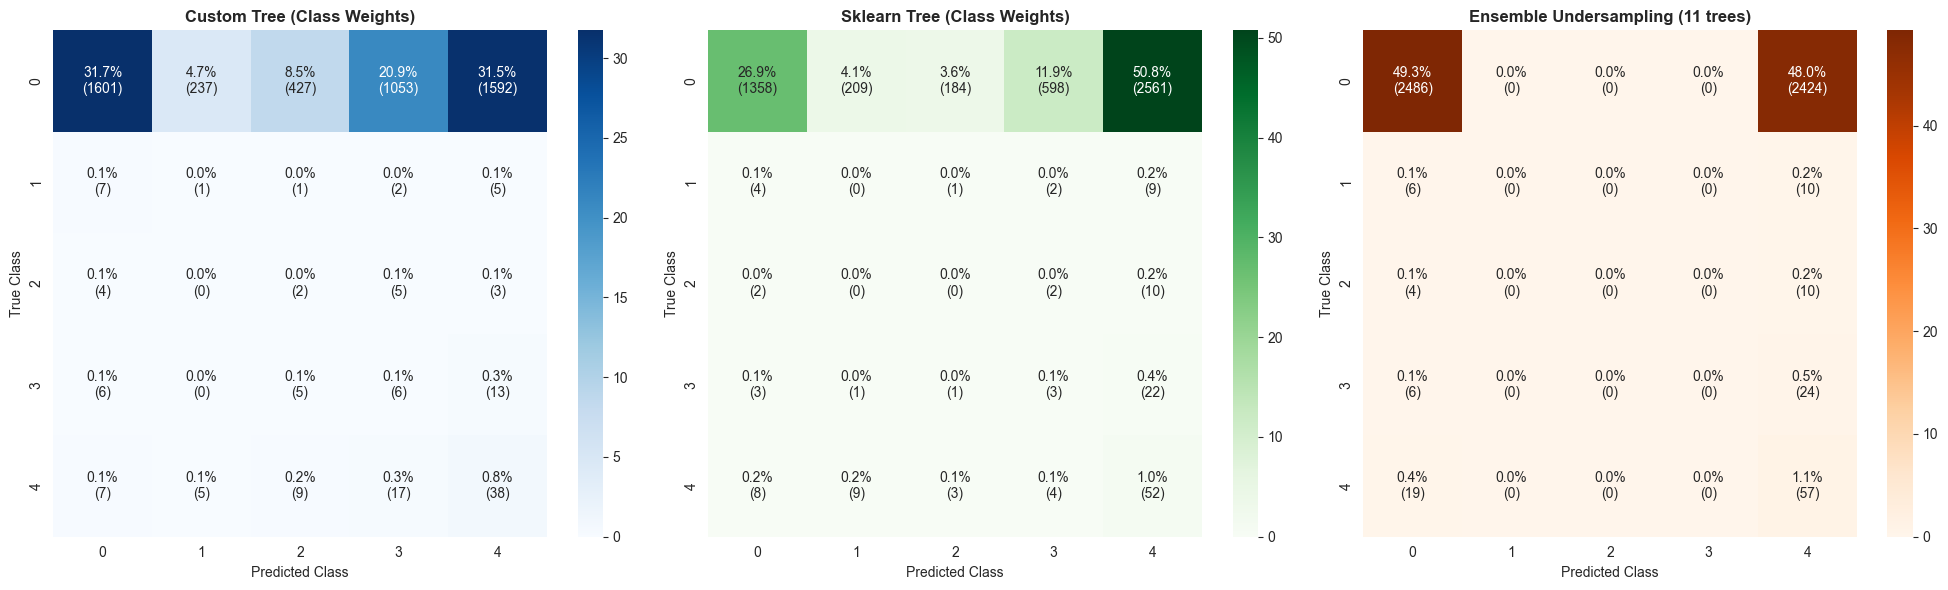


 Key Observations:
   - Custom/Sklearn: Use class weights to handle imbalance
   - Ensemble: 11 trees trained on balanced batches (no weights)
   - Compare diagonal (correct predictions) across all three models
   - Check Class 4 recall: critical for catching imminent failures!


In [47]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Custom Single Tree
cm_custom = confusion_matrix(y_val, y_val_pred_custom)
cm_custom_pct = cm_custom.astype('float') / cm_custom.sum() * 100
annot_custom = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                         for row_pct, row_count in zip(cm_custom_pct, cm_custom)])
sns.heatmap(cm_custom_pct, annot=annot_custom, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
axes[0].set_title('Custom Tree (Class Weights)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Class')
axes[0].set_xlabel('Predicted Class')

# Sklearn
cm_sklearn = confusion_matrix(y_val, y_val_pred_sklearn)
cm_sklearn_pct = cm_sklearn.astype('float') / cm_sklearn.sum() * 100
annot_sklearn = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                          for row_pct, row_count in zip(cm_sklearn_pct, cm_sklearn)])
sns.heatmap(cm_sklearn_pct, annot=annot_sklearn, fmt='', cmap='Greens', ax=axes[1],
            xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
axes[1].set_title('Sklearn Tree (Class Weights)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Class')
axes[1].set_xlabel('Predicted Class')

# Ensemble Undersampling
cm_ensemble = confusion_matrix(y_val, y_val_pred_ensemble)
cm_ensemble_pct = cm_ensemble.astype('float') / cm_ensemble.sum() * 100
annot_ensemble = np.array([[f'{pct:.1f}%\n({count})' for pct, count in zip(row_pct, row_count)] 
                           for row_pct, row_count in zip(cm_ensemble_pct, cm_ensemble)])
sns.heatmap(cm_ensemble_pct, annot=annot_ensemble, fmt='', cmap='Oranges', ax=axes[2],
            xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
axes[2].set_title(f'Ensemble Undersampling ({ensemble_model.n_trees} trees)', 
                  fontsize=12, fontweight='bold')
axes[2].set_ylabel('True Class')
axes[2].set_xlabel('Predicted Class')

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print(f"   - Custom/Sklearn: Use class weights to handle imbalance")
print(f"   - Ensemble: {ensemble_model.n_trees} trees trained on balanced batches (no weights)")
print(f"   - Compare diagonal (correct predictions) across all three models")
print(f"   - Check Class 4 recall: critical for catching imminent failures!")